In [1]:
import pandas as pd
import numpy as np

import plotly.io as pio
import plotly.graph_objs as go
import plotly.express as px

pio.renderers.default = "notebook_connected"

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
plt.rcParams["mathtext.default"] = 'regular'

In [2]:
import glob, re

ansi_match = re.compile(r'\x1B(?:[@-Z\\-_]|\[[0-?]*[ -/]*[@-~])')
name_match = re.compile(r'(.*)-(.*)-(.*)-(.*)T.out')
time_match = re.compile(r'\[Morse.*\].*processed.*\[(.*)s\|.*\|.*\]')

def get_time(file):
    with open(file) as f:
        lines = f.readlines()

    for line in lines:
        line = ansi_match.sub('', line)
        
        if m := time_match.match(line):
            return float(m.groups()[0])

    return None

files = glob.glob('miranda-*-*-*.out')

entries = [ { 
    'dataset': m.groups()[0],
    'method':  m.groups()[1],
    'size':    int(m.groups()[2]),
    'cores':   int(m.groups()[3]),
    'time':    get_time(f),
} for f in files if (m := re.match('(.*)-(.*)-(.*)-(.*)T.out', f)) ]

benchmarks = pd.DataFrame(entries)
benchmarks

,dataset,method,size,cores,time
0,miranda,msspl,128,16,0.809
1,miranda,msspl,128,1,4.364
2,miranda,msspl,256,1,45.667
3,miranda,msspl,512,1,521.206
4,miranda,msspl,1024,1,5113.742
...,...,...,...,...,...
67,miranda,mssfast,1024,16,251.106
68,miranda,mssfast,128,32,0.310
69,miranda,mssfast,256,32,2.327
70,miranda,mssfast,512,32,17.108


In [12]:
tmp = (benchmarks
    .query(f'dataset == "miranda"')
    .assign(cells = lambda df: df['size']**3)
    .set_index('cores')
    .sort_index()
)

# speedup
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(18,4))
axes = [axes[0], axes[2], axes[1]]

for (method, data), ax in zip(tmp.groupby('method'), axes):
    for g, d in data.groupby('size'):
        ax.loglog(d.index, d.time.loc[1] / d.time, 'o-', label=f"${g}^3$ cells")

    ticks = tmp.index.unique()
    ax.set_xlabel('# cores')
    ax.set_xticks(ticks, minor=False)
    ax.set_xticklabels([ str(t) for t in ticks ])

    ax.set_ylabel('speedup factor')

    ax.set_title(f"{method.upper()}", fontweight='bold')
    ax.grid()

fig.legend(*ax.get_legend_handles_labels(), loc='lower center', ncol=4, bbox_to_anchor=(0.5, -.1), prop={"family":"Times New Roman"})
fig.set_tight_layout(True)
fig.show()
fig.savefig('miranda-speedup.pdf', bbox_inches='tight')

KeyError: 'size'

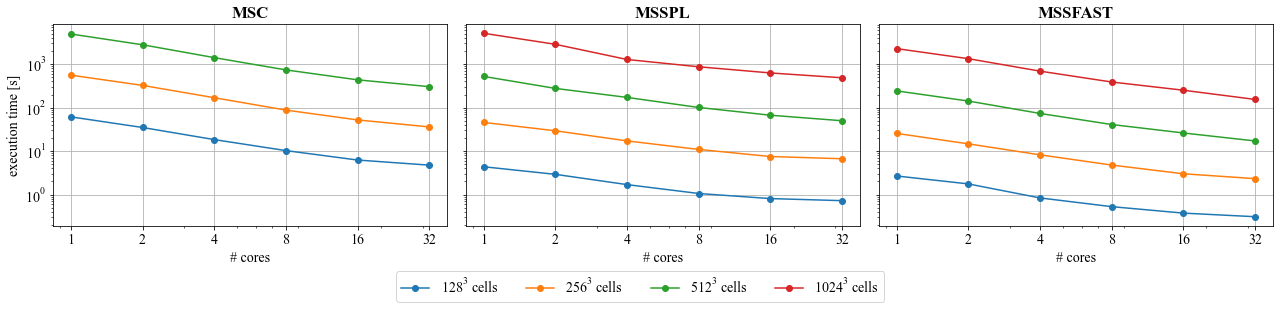

In [4]:
# runtime vs core count
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(18,4))
axes = [axes[0], axes[2], axes[1]]

for (method, data), ax in zip(tmp.groupby('method'), axes):
    for g, d in data.groupby('size'):
        ax.loglog(d.index, d.time, 'o-', label=f"${g}^3$ cells")

    ticks = tmp.index.unique()
    ax.set_xlabel('# cores')
    ax.set_xticks(ticks)
    ax.set_xticklabels([ str(t) for t in ticks ])


    ax.set_title(f"{method.upper()}", fontweight='bold')
    ax.grid()

axes[0].set_ylabel('execution time [s]')
fig.legend(*ax.get_legend_handles_labels(), loc='lower center', ncol=4, bbox_to_anchor=(0.5, -.1))
fig.set_tight_layout(True)
fig.show()
fig.savefig('miranda-strong.pdf', bbox_inches='tight')


In [5]:
def fun(x):
    return x.assign(speedup = lambda q: q.time.loc[1] / q.time)

(tmp
    .groupby(['method', 'size'])
    .apply(fun)
    .reset_index()
    .drop(columns = ['dataset', 'time', 'cells'])
    .sort_values(['method', 'size', 'cores'])
    .set_index(['method', 'size', 'cores'])
    .unstack()
)

speedup                                                    
cores             1         2         4         8          16         32
method  size                                                            
msc     128      1.0  1.754405  3.330850  5.964839   9.833173  12.879285
        256      1.0  1.721830  3.303164  6.365418  10.714000  15.500917
        512      1.0  1.766342  3.492344  6.689816  11.322116  16.241491
        1024     NaN       NaN       NaN       NaN        NaN        NaN
mssfast 128      1.0  1.520159  3.194511  5.070076   7.138667   8.635484
        256      1.0  1.740203  3.110867  5.348555   8.483056  10.972927
        512      1.0  1.710078  3.299515  5.928580   9.275993  14.158522
        1024     1.0  1.703293  3.295129  5.858051   9.047661  14.736282
msspl   128      1.0  1.494521  2.574631  4.120869   5.394314   6.019310
        256      1.0  1.558335  2.662178  4.182343   6.085688   6.848680
        512      1.0  1.886964  3.037614  5.180768   7.798399  10.454438
        1024     1.0  1.793177  4.005083  5.890675   8.164157  10.540169

In [6]:
tmp = (benchmarks
    .drop(columns='dataset')
    .sort_values(['method', 'size', 'cores'])
    .set_index(['method', 'size', 'cores'])
    .unstack()
    .rename(index = { 'method': 'Method' })
    .fillna('–')
)

tmp.columns = tmp.columns.get_level_values(1).rename(None)
tmp = tmp.reset_index().assign(size = lambda df: '$' + df['size'].astype(str) + '^3$' )

tmp

,method,size,1,2,4,8,16,32
0,msc,$128^3$,61.241,34.907,18.386,10.267,6.228,4.755
1,msc,$256^3$,557.878,324.003,168.892,87.642,52.07,35.99
2,msc,$512^3$,4924.079,2787.727,1409.964,736.056,434.908,303.179
3,msc,$1024^3$,–,–,–,–,–,–
4,mssfast,$128^3$,2.677,1.761,0.838,0.528,0.375,0.31
5,mssfast,$256^3$,25.534,14.673,8.208,4.774,3.01,2.327
6,mssfast,$512^3$,242.224,141.645,73.412,40.857,26.113,17.108
7,mssfast,$1024^3$,2271.922,1333.841,689.479,387.829,251.106,154.172
8,msspl,$128^3$,4.364,2.92,1.695,1.059,0.809,0.725
9,msspl,$256^3$,45.667,29.305,17.154,10.919,7.504,6.668


In [8]:
print(tmp.style.to_latex())

\begin{tabular}{lllllllll}
 & method & size & 1 & 2 & 4 & 8 & 16 & 32 \\
0 & msc & $128^3$ & 61.241000 & 34.907000 & 18.386000 & 10.267000 & 6.228000 & 4.755000 \\
1 & msc & $256^3$ & 557.878000 & 324.003000 & 168.892000 & 87.642000 & 52.070000 & 35.990000 \\
2 & msc & $512^3$ & 4924.079000 & 2787.727000 & 1409.964000 & 736.056000 & 434.908000 & 303.179000 \\
3 & msc & $1024^3$ & – & – & – & – & – & – \\
4 & mssfast & $128^3$ & 2.677000 & 1.761000 & 0.838000 & 0.528000 & 0.375000 & 0.310000 \\
5 & mssfast & $256^3$ & 25.534000 & 14.673000 & 8.208000 & 4.774000 & 3.010000 & 2.327000 \\
6 & mssfast & $512^3$ & 242.224000 & 141.645000 & 73.412000 & 40.857000 & 26.113000 & 17.108000 \\
7 & mssfast & $1024^3$ & 2271.922000 & 1333.841000 & 689.479000 & 387.829000 & 251.106000 & 154.172000 \\
8 & msspl & $128^3$ & 4.364000 & 2.920000 & 1.695000 & 1.059000 & 0.809000 & 0.725000 \\
9 & msspl & $256^3$ & 45.667000 & 29.305000 & 17.154000 & 10.919000 & 7.504000 & 6.668000 \\
10 & msspl & $512^3$ 

# WSM

In [9]:
files = glob.glob('robin_tests/log/viscous_*_*T.log')

entries = [ { 
    'dataset': m.groups()[0],
    'method':  m.groups()[1],
    'cores':   int(m.groups()[2]),
    'time':    get_time(f),
} for f in files if (m := re.match('robin_tests/log/(.*)_(.*)_(.*)T.log', f)) ]

benchmarks = pd.DataFrame(entries)
benchmarks

,dataset,method,cores,time
0,viscous,msswall,24,0.127
1,viscous,mssfast,24,0.098
2,viscous,mssfine,24,0.148
3,viscous,msswall,1,1.330
4,viscous,msswall,4,0.459
5,viscous,msswall,8,0.256
6,viscous,msswall,12,0.197
7,viscous,msswall,16,0.166
8,viscous,msswall,20,0.135
9,viscous,mssfast,1,1.199


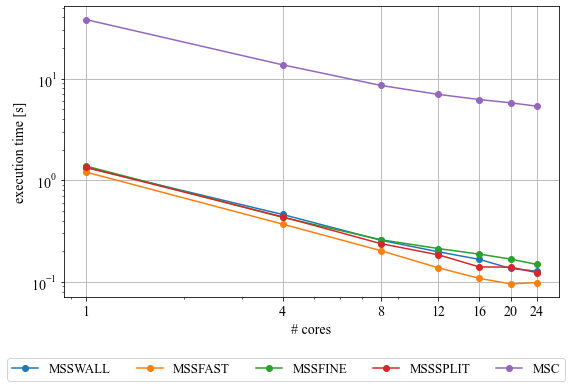

In [19]:
fig, ax = plt.subplots(figsize=(8,5))

for method in ['msswall', 'mssfast', 'mssfine', 'msssplit', 'msc']:

    tmp = (benchmarks
        .query(f'dataset == "viscous" and method == "{method}"')
        .sort_values(['cores'])
    )

    ax.loglog(tmp.cores, tmp.time, 'o-', label=method.upper())

ticks = tmp.cores.unique()
ax.set_xlabel('# cores')
ax.set_xticks(ticks, minor=False)
ax.set_xticklabels([ str(t) for t in ticks ])
ax.grid()

# speedup
# fig, axes = plt.subplots(1, 3, sharey=True, figsize=(16,4))
# axes = [axes[0], axes[2], axes[1]]

# for (method, data), ax in zip(tmp.groupby('method'), axes):
#     for g, d in data.groupby('size'):
#         ax.loglog(d.index, d.time.loc[1] / d.time, 'o-', label=f"${g}^3$ cells")

#     ticks = tmp.index.unique()
#     ax.set_xlabel('# cores')
#     ax.set_xticks(ticks, minor=False)
#     ax.set_xticklabels([ str(t) for t in ticks ])

ax.set_ylabel('execution time [s]')

    # ax.set_title(f"{method.upper()}", fontweight='bold')
#     ax.grid()

fig.legend(*ax.get_legend_handles_labels(), loc='lower center', ncol=5, bbox_to_anchor=(0.5, -.1), prop={"family":"Times New Roman", "size": 13})
fig.set_tight_layout(True)
fig.show()
fig.savefig('viscous-strong.pdf', bbox_inches='tight')

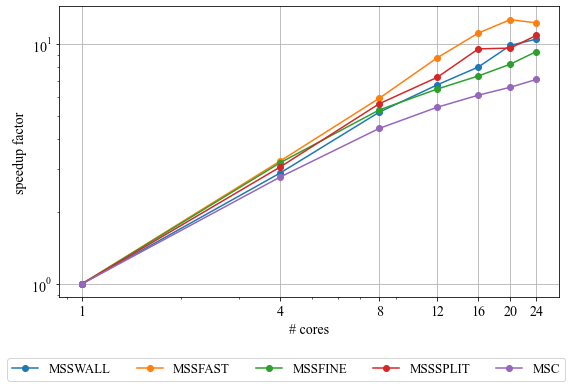

In [18]:
fig, ax = plt.subplots(figsize=(8,5))

for method in ['msswall', 'mssfast', 'mssfine', 'msssplit', 'msc']:

    tmp = (benchmarks
        .query(f'dataset == "viscous" and method == "{method}"')
        .sort_values(['cores'])
        .set_index('cores')
    )

    ax.loglog(tmp.index, tmp.time.loc[1] / tmp.time, 'o-', label=method.upper())

ticks = tmp.index.unique()
ax.set_xlabel('# cores')
ax.set_xticks(ticks, minor=False)
ax.set_xticklabels([ str(t) for t in ticks ])
ax.grid()

# speedup
# fig, axes = plt.subplots(1, 3, sharey=True, figsize=(16,4))
# axes = [axes[0], axes[2], axes[1]]

# for (method, data), ax in zip(tmp.groupby('method'), axes):
#     for g, d in data.groupby('size'):
#         ax.loglog(d.index, d.time.loc[1] / d.time, 'o-', label=f"${g}^3$ cells")

#     ticks = tmp.index.unique()
#     ax.set_xlabel('# cores')
#     ax.set_xticks(ticks, minor=False)
#     ax.set_xticklabels([ str(t) for t in ticks ])

ax.set_ylabel('speedup factor')

    # ax.set_title(f"{method.upper()}", fontweight='bold')
#     ax.grid()

fig.legend(*ax.get_legend_handles_labels(), loc='lower center', ncol=5, bbox_to_anchor=(0.5, -.1), prop={"family":"Times New Roman", "size": 13})
fig.set_tight_layout(True)
fig.show()
fig.savefig('viscous-speedup.pdf', bbox_inches='tight')

In [23]:
tmp = (benchmarks
    .drop(columns='dataset')
    .sort_values(['method', 'cores'])
    .set_index(['method', 'cores'])
    .unstack()
    .rename(index = { 'method': 'Method' })
    .fillna('–')
)

tmp.columns = tmp.columns.get_level_values(1).rename(None)
# tmp = tmp.reset_index().assign(size = lambda df: '$' + df['size'].astype(str) + '^3$' )

print( tmp.reset_index().style.to_latex())

\begin{tabular}{llrrrrrrr}
 & method & 1 & 4 & 8 & 12 & 16 & 20 & 24 \\
0 & msc & 38.082000 & 13.660000 & 8.565000 & 6.991000 & 6.225000 & 5.772000 & 5.355000 \\
1 & mssfast & 1.199000 & 0.369000 & 0.202000 & 0.137000 & 0.108000 & 0.095000 & 0.098000 \\
2 & mssfine & 1.375000 & 0.430000 & 0.259000 & 0.212000 & 0.187000 & 0.167000 & 0.148000 \\
3 & msssplit & 1.335000 & 0.435000 & 0.237000 & 0.184000 & 0.140000 & 0.139000 & 0.123000 \\
4 & msswall & 1.330000 & 0.459000 & 0.256000 & 0.197000 & 0.166000 & 0.135000 & 0.127000 \\
\end{tabular}



In [20]:
print(tmp.style.to_latex())

\begin{tabular}{lllrr}
 & dataset & method & cores & time \\
27 & viscous & msc & 1 & 38.082000 \\
28 & viscous & msc & 4 & 13.660000 \\
29 & viscous & msc & 8 & 8.565000 \\
30 & viscous & msc & 12 & 6.991000 \\
31 & viscous & msc & 16 & 6.225000 \\
32 & viscous & msc & 20 & 5.772000 \\
33 & viscous & msc & 24 & 5.355000 \\
\end{tabular}

